# 图像卷积
:label:`sec_conv_layer`

上节我们解析了卷积层的原理，现在我们看看它的实际应用。由于卷积神经网络的设计是用于探索图像数据，本节我们将以图像为例。

## 互相关运算

严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是*互相关运算*（cross-correlation），而不是卷积运算。
根据 :numref:`sec_why-conv`中的描述，在卷积层中，输入张量和核张量通过(**互相关运算**)产生输出张量。

首先，我们暂时忽略通道（第三维）这一情况，看看如何处理二维图像数据和隐藏表示。在 :numref:`fig_correlation`中，输入是高度为$3$、宽度为$3$的二维张量（即形状为$3 \times 3$）。卷积核的高度和宽度都是$2$，而卷积核窗口（或卷积窗口）的形状由内核的高度和宽度决定（即$2 \times 2$）。
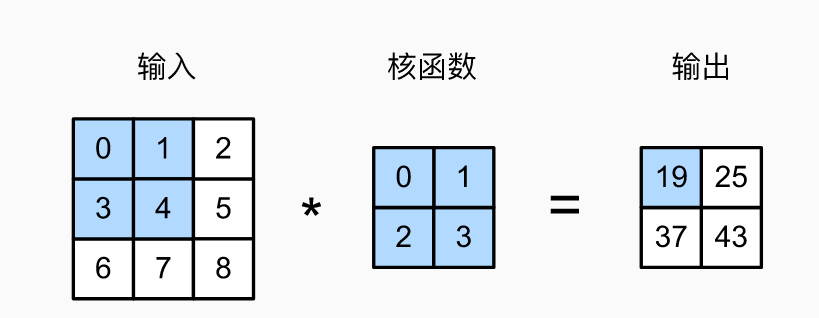

![二维互相关运算。阴影部分是第一个输出元素，以及用于计算输出的输入张量元素和核张量元素：$0\times0+1\times1+3\times2+4\times3=19$.](../img/correlation.svg)
:label:`fig_correlation`

在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。
当卷积窗口滑动到新一个位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。
在如上例子中，输出张量的四个元素由二维互相关运算得到，这个输出高度为$2$、宽度为$2$，如下所示：

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

注意，输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1，
而卷积核只与图像中每个大小完全适合的位置进行互相关运算。
所以，输出大小等于输入大小$n_h \times n_w$减去卷积核大小$k_h \times k_w$，即：

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

这是因为我们需要足够的空间在图像上“移动”卷积核。稍后，我们将看到如何通过在图像边界周围填充零来保证有足够的空间移动卷积核，从而保持输出大小不变。
接下来，我们在`corr2d`函数中实现如上过程，该函数接受输入张量`X`和卷积核张量`K`，并返回输出张量`Y`。


In [4]:
import torch
from torch import nn
from d2l import torch as d2l
def corr2d(X,K): #save
    #计算二维互相关运算
    h,w=K.shape
    Y=torch.zeros(X.shape[0]-h+1,X.shape[1]-w+1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=(X[i:i+h,j:j+w]*K).sum()
    return Y

通过 :numref:`fig_correlation`的输入张量`X`和卷积核张量`K`，我们来[**验证上述二维互相关运算的输出**]。

In [5]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 卷积层

卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。
所以，卷积层中的两个被训练的参数是卷积核权重和标量偏置。
就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也随机初始化卷积核权重。

基于上面定义的`corr2d`函数[**实现二维卷积层**]。在`__init__`构造函数中，将`weight`和`bias`声明为两个模型参数。前向传播函数调用`corr2d`函数并添加偏置。

In [7]:
class Cov2D(nn.Module):
    def __init__(self,Kernel_size):
        super().__init__()
        self.weight=nn.Parameter(torch.rand(Kernel_size))
        self.biad=nn.Parameter(torch.zeros(1))
    def forward(self,x):
        return corr2d(x,self.weight)+self.bias
    

高度和宽度分别为$h$和$w$的卷积核可以被称为$h \times w$卷积或$h \times w$卷积核。
我们也将带有$h \times w$卷积核的卷积层称为$h \times w$卷积层。

## 图像中目标的边缘检测

如下是[**卷积层的一个简单应用：**]通过找到像素变化的位置，来(**检测图像中不同颜色的边缘**)。
首先，我们构造一个$6\times 8$像素的黑白图像。中间四列为黑色（$0$），其余像素为白色（$1$）。


In [8]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来，我们构造一个高度为$1$、宽度为$2$的卷积核`K`。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。

In [9]:
K = torch.tensor([[1.0, -1.0]])

现在，我们对参数`X`（输入）和`K`（卷积核）执行互相关运算。
如下所示，[**输出`Y`中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘**]，其他情况的输出为$0$。

In [10]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

现在我们将输入的二维图像转置，再进行如上的互相关运算。 其输出如下，之前检测到的垂直边缘消失了。 不出所料，这个卷积核K只可以检测垂直边缘，无法检测水平边缘。

In [11]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习卷积核

如果我们只需寻找黑白边缘，那么以上`[1, -1]`的边缘检测器足以。然而，当有了更复杂数值的卷积核，或者连续的卷积层时，我们不可能手动设计滤波器。那么我们是否可以[**学习由`X`生成`Y`的卷积核**]呢？

现在让我们看看是否可以通过仅查看“输入-输出”对来学习由`X`生成`Y`的卷积核。
我们先构造一个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，我们比较`Y`与卷积层输出的平方误差，然后计算梯度来更新卷积核。为了简单起见，我们在此使用内置的二维卷积层，并忽略偏置。

In [19]:
#构造一个二维的卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d=nn.Conv2d(1,1,kernel_size=(1,2),bias=False)
# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X=X.reshape((1,1,6,8))
Y=Y.reshape((1,1,6,7))
lr=3e-2 #学习率

for i in range(10):
    Y_hat=conv2d(X)
    l=(Y_hat-Y)**2
    conv2d.zero_grad()
    l.sum().backward()
    #迭代卷积核
    conv2d.weight.data[:]-=lr*conv2d.weight.grad
    if (i+1)%2==0:
        print(f'epoch{i+1},loss{l.sum():.3f}')

epoch2,loss5.156
epoch4,loss1.510
epoch6,loss0.517
epoch8,loss0.195
epoch10,loss0.077


在10次迭代之后，误差已经降到足够低。现在我们来看看我们所学的卷积核的权重张量。

In [20]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9635, -1.0201]])

细心的读者一定会发现，我们学习到的卷积核权重非常接近我们之前定义的卷积核K。

## 互相关和卷积

回想一下我们在 :numref:`sec_why-conv`中观察到的互相关和卷积运算之间的对应关系。
为了得到正式的*卷积*运算输出，我们需要执行 :eqref:`eq_2d-conv-discrete`中定义的严格卷积运算，而不是互相关运算。
幸运的是，它们差别不大，我们只需水平和垂直翻转二维卷积核张量，然后对输入张量执行*互相关*运算。

值得注意的是，由于卷积核是从数据中学习到的，因此无论这些层执行严格的卷积运算还是互相关运算，卷积层的输出都不会受到影响。
为了说明这一点，假设卷积层执行*互相关*运算并学习 :numref:`fig_correlation`中的卷积核，该卷积核在这里由矩阵$\mathbf{K}$表示。
假设其他条件不变，当这个层执行严格的*卷积*时，学习的卷积核$\mathbf{K}'$在水平和垂直翻转之后将与$\mathbf{K}$相同。
也就是说，当卷积层对 :numref:`fig_correlation`中的输入和$\mathbf{K}'$执行严格*卷积*运算时，将得到与互相关运算 :numref:`fig_correlation`中相同的输出。

为了与深度学习文献中的标准术语保持一致，我们将继续把“互相关运算”称为卷积运算，尽管严格地说，它们略有不同。
此外，对于卷积核张量上的权重，我们称其为*元素*。

## 特征映射和感受野

如在 :numref:`subsec_why-conv-channels`中所述， :numref:`fig_correlation`中输出的卷积层有时被称为*特征映射*（feature map），因为它可以被视为一个输入映射到下一层的空间维度的转换器。
在卷积神经网络中，对于某一层的任意元素$x$，其*感受野*（receptive field）是指在前向传播期间可能影响$x$计算的所有元素（来自所有先前层）。

请注意，感受野可能大于输入的实际大小。让我们用 :numref:`fig_correlation`为例来解释感受野：
给定$2 \times 2$卷积核，阴影输出元素值$19$的感受野是输入阴影部分的四个元素。
假设之前输出为$\mathbf{Y}$，其大小为$2 \times 2$，现在我们在其后附加一个卷积层，该卷积层以$\mathbf{Y}$为输入，输出单个元素$z$。
在这种情况下，$\mathbf{Y}$上的$z$的感受野包括$\mathbf{Y}$的所有四个元素，而输入的感受野包括最初所有九个输入元素。
因此，当一个特征图中的任意元素需要检测更广区域的输入特征时，我们可以构建一个更深的网络。

## 小结

* 二维卷积层的核心计算是二维互相关运算。最简单的形式是，对二维输入数据和卷积核执行互相关操作，然后添加一个偏置。
* 我们可以设计一个卷积核来检测图像的边缘。
* 我们可以从数据中学习卷积核的参数。
* 学习卷积核时，无论用严格卷积运算或互相关运算，卷积层的输出不会受太大影响。
* 当需要检测输入特征中更广区域时，我们可以构建一个更深的卷积网络。

## 练习

1. 构建一个具有对角线边缘的图像`X`。
    1. 如果将本节中举例的卷积核`K`应用于`X`，会发生什么情况？
    1. 如果转置`X`会发生什么？
    1. 如果转置`K`会发生什么？
1. 在我们创建的`Conv2D`自动求导时，有什么错误消息？
1. 如何通过改变输入张量和卷积核张量，将互相关运算表示为矩阵乘法？
1. 手工设计一些卷积核：
    1. 二阶导数的核的形式是什么？
    1. 积分的核的形式是什么？
    1. 得到$d$次导数的最小核的大小是多少？
